In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

1.	Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [2]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=['date'])
print(data.shape)
data.head()

(295404, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295404 entries, 0 to 295403
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    295404 non-null  object        
 1   continent                                   281388 non-null  object        
 2   location                                    295404 non-null  object        
 3   date                                        295404 non-null  datetime64[ns]
 4   total_cases                                 259937 non-null  float64       
 5   new_cases                                   287174 non-null  float64       
 6   new_cases_smoothed                          285910 non-null  float64       
 7   total_deaths                                239564 non-null  float64       
 8   new_deaths                                  287252 non-null  float64      

In [4]:
data.new_cases = data.new_cases.replace(0, 1)

In [5]:
data = data[(data.location == 'Russia') & (data.date >= dt.datetime(2020, 3, 3))]
data['n_day'] = np.arange(len(data)) + 1
data = data[['date', 'total_cases', 'new_cases', 'n_day']]
data

,date,total_cases,new_cases,n_day
216234,2020-03-03,3.0,1.0,1
216235,2020-03-04,3.0,1.0,2
216236,2020-03-05,3.0,1.0,3
216237,2020-03-06,4.0,1.0,4
216238,2020-03-07,4.0,1.0,5
...,...,...,...,...
217337,2023-03-11,22411108.0,12241.0,1104
217338,2023-03-12,22423093.0,11985.0,1105
217339,2023-03-13,22433361.0,10268.0,1106
217340,2023-03-14,22442887.0,9526.0,1107


In [6]:
train, test = data.iloc[:50, :], data.iloc[50:, :]
train.shape, test.shape

((50, 4), (1058, 4))

2.	Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

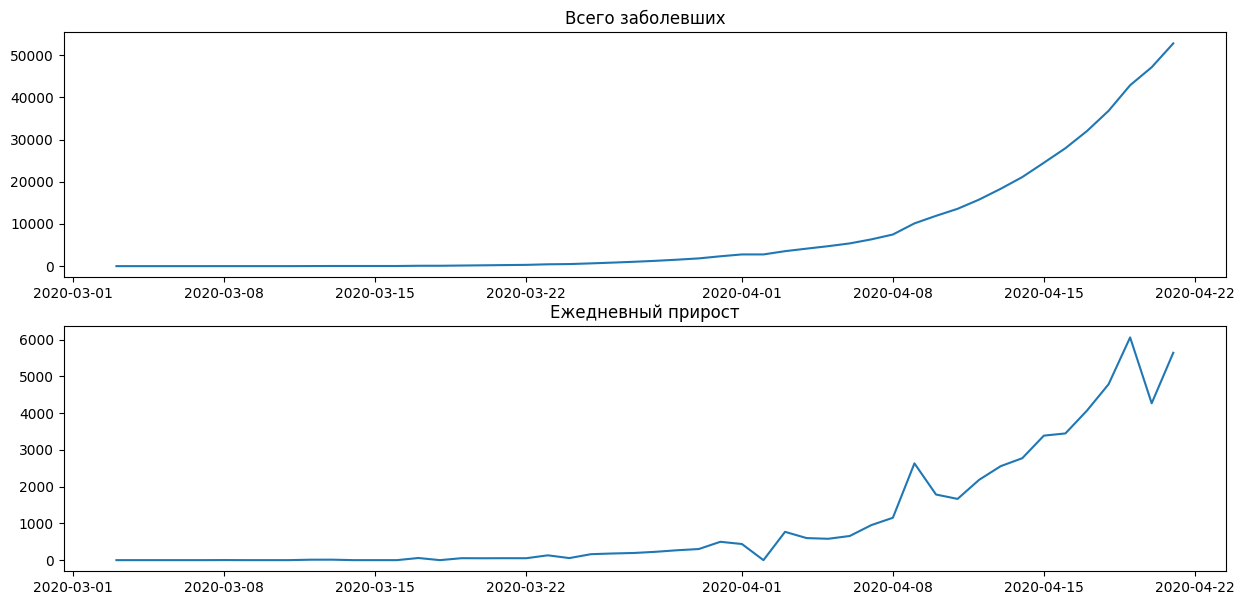

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15, 7))

ax[0].plot(train.date, train.total_cases)
ax[0].set_title('Всего заболевших')

ax[1].plot(train.date, train.new_cases)
ax[1].set_title('Ежедневный прирост')

plt.show()

a.	Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train[['n_day']], np.log(train.total_cases))
pred = model.predict(train[['n_day']])

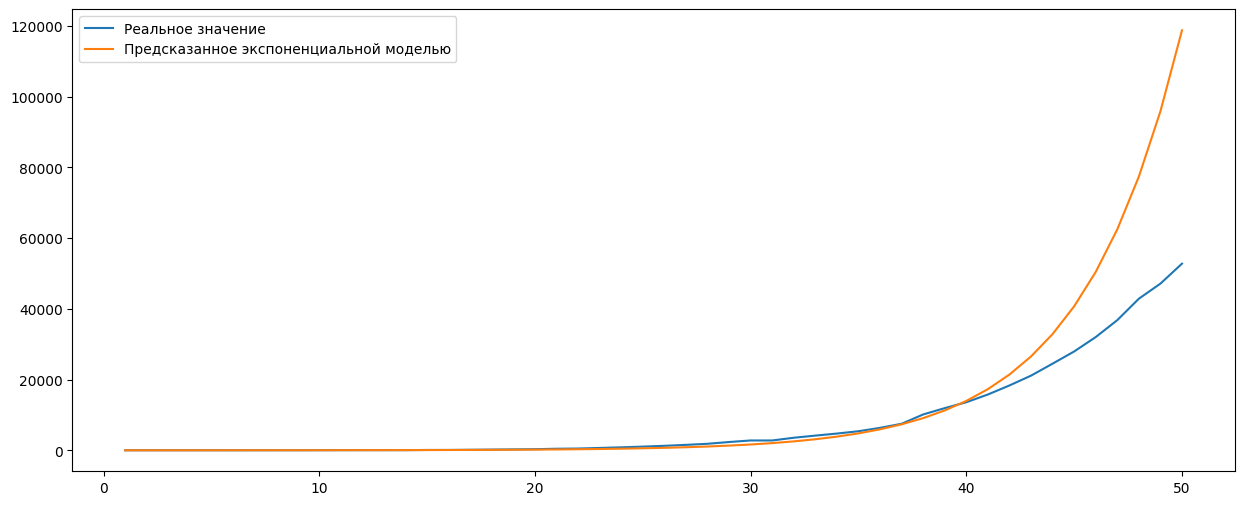

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(train['n_day'], train['total_cases'], label='Реальное значение')
ax.plot(train['n_day'], np.exp(pred.reshape(-1, 1)), label='Предсказанное экспоненциальной моделью')
ax.legend()

plt.show()

b.	Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [10]:
sigma_noise = np.std(model.predict(train[['n_day']]) - np.log(train['total_cases']))
sigma_noise

0.4498899109116322

In [11]:
mu, sigma = np.array([0, 0]), np.array([[50, 0], [0, 50]])

def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n


for i in range(train.shape[0]):
    px = train.iloc[i]['n_day']
    py = np.log(train.iloc[i]['total_cases'])
    mu, sigma = bayesian_update(mu, sigma, px, py, sigma_noise)
    
mu, sigma

(array([0.97898829, 0.21411599]),
 array([[ 1.66821776e-02, -4.95510180e-04],
        [-4.95510180e-04,  1.94333450e-05]]))

c.	Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [12]:
N = 500
xs = np.linspace(0, 50, N)

In [13]:
def myplot_sample_lines(mu, sigma, xs, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1] * xs), 'k-', lw=.4, alpha=.6)

    plt.ylim((0, 100000))
    plt.xlim((0, 50))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

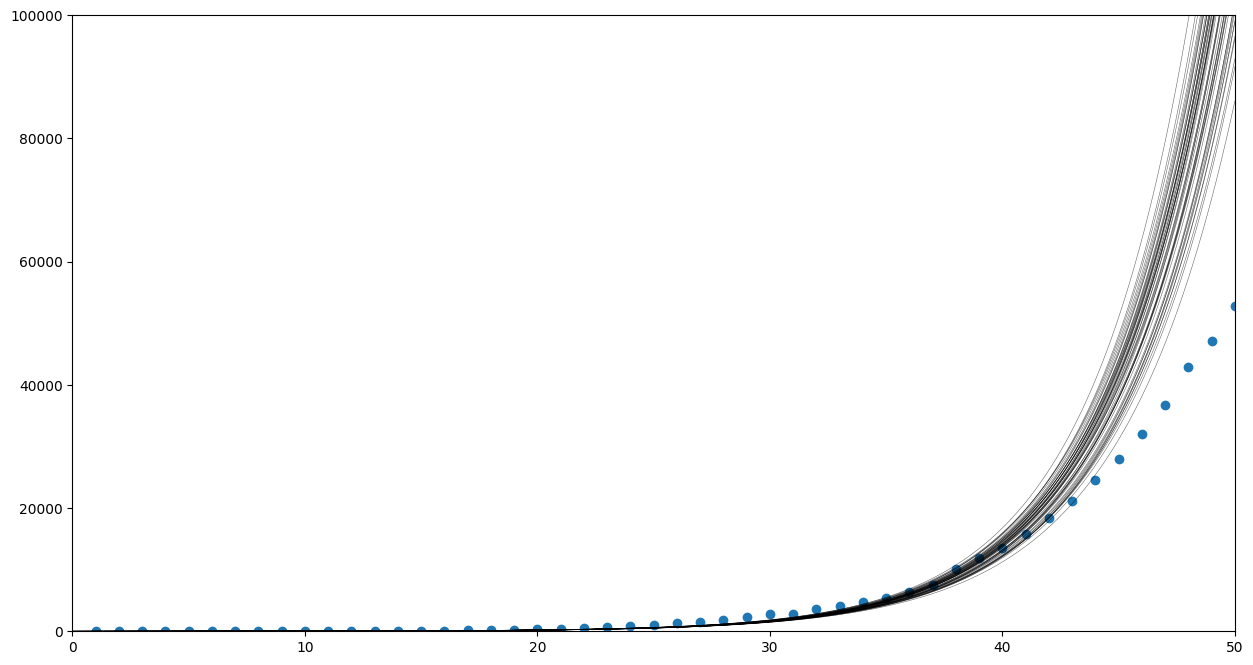

In [14]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.scatter(train['n_day'], train['total_cases'], label='True')

myplot_sample_lines(mu, sigma, xs, 50)

In [15]:
xs = np.array(range(1, 200))
my_w = np.random.multivariate_normal(mu, sigma, 2500)

distrs = []

for w in my_w:
    distrs.append(np.exp(w[0] + w[1] * xs))
    
mean_distrs = np.array(distrs).mean(axis=0)

Прогноз общего числа заболевших к 2020-05-01 1023329 человек
Прогноз общего числа заболевших к 2020-06-01 804101478 человек
Прогноз общего числа заболевших к 2020-09-01 351616097401810688 человек


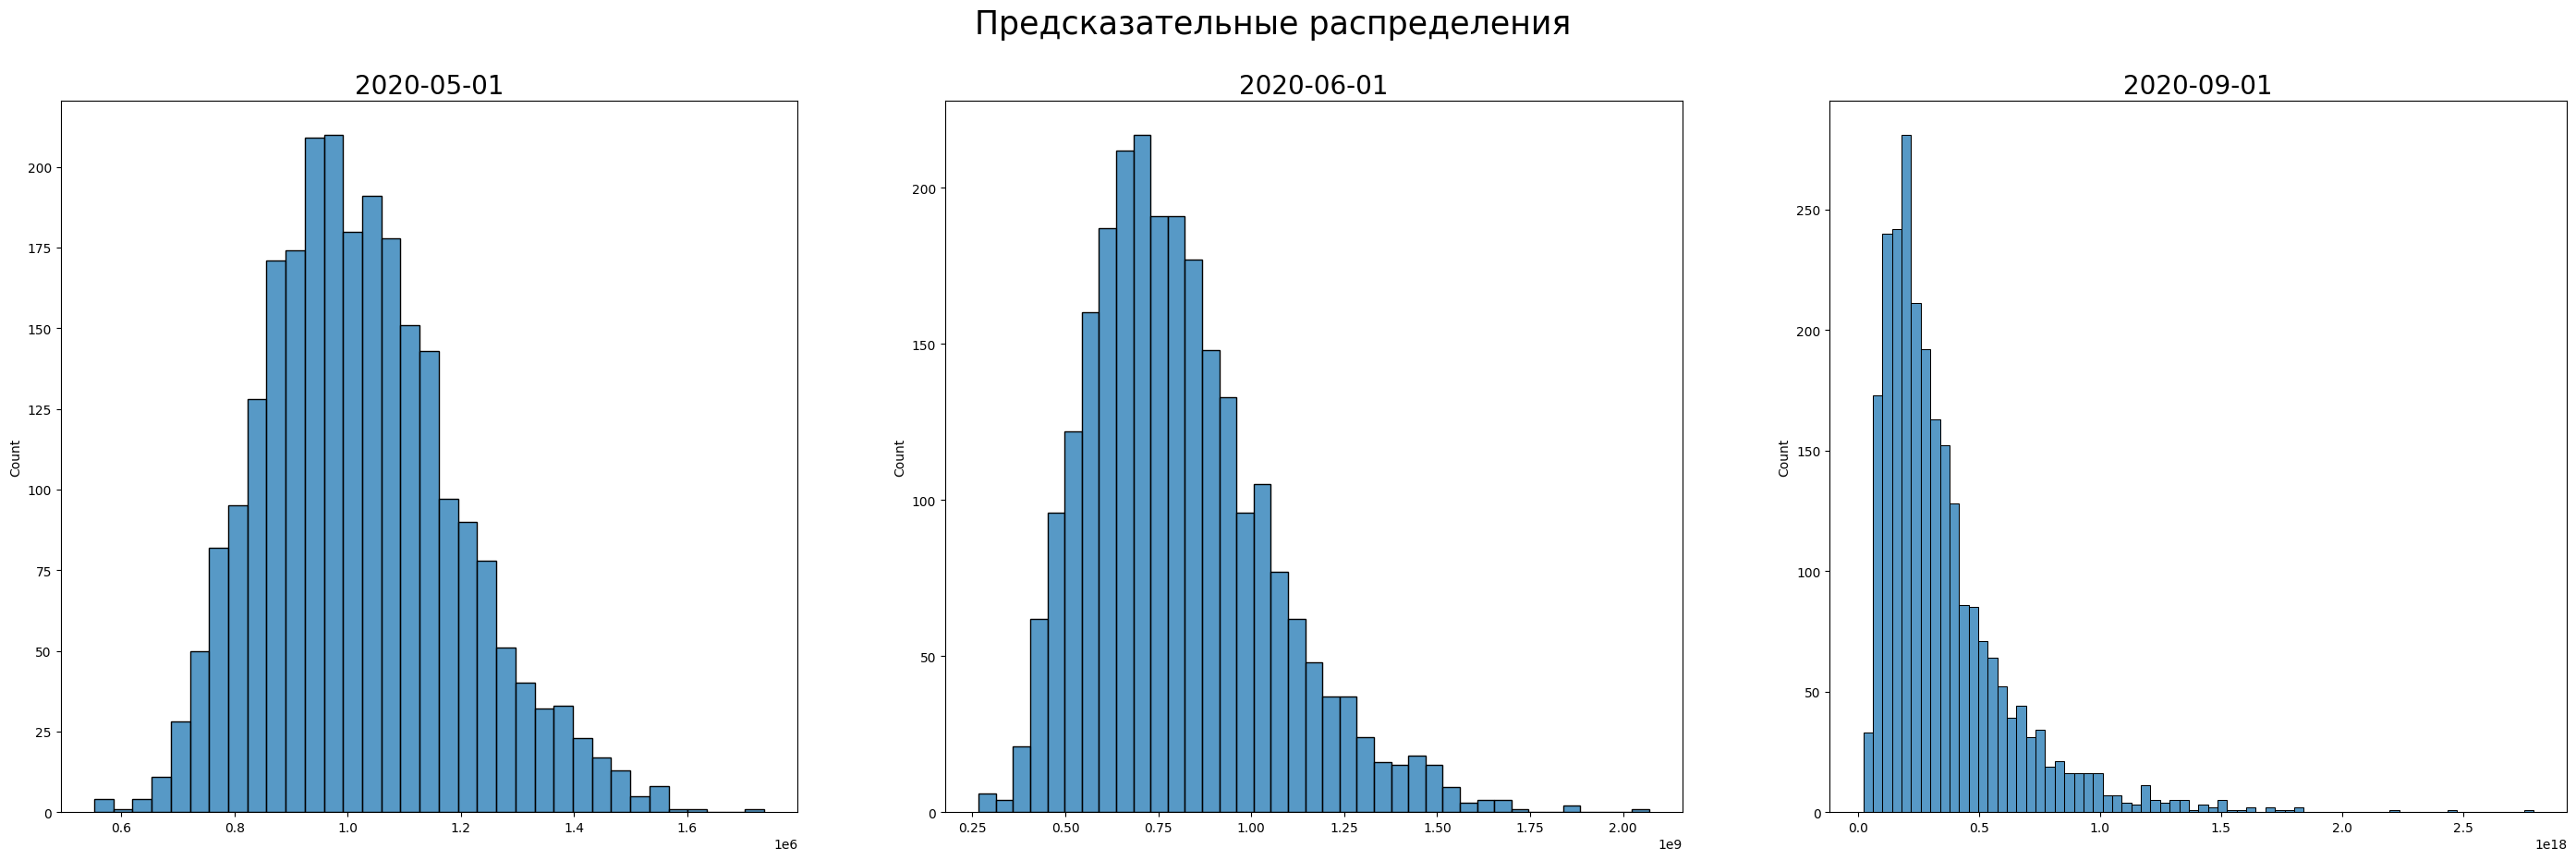

In [16]:
dates = ['2020-05-01','2020-06-01','2020-09-01']

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
plt.suptitle('Предсказательные распределения', fontsize=25)

for i, date in enumerate(dates):
    n_day = (pd.to_datetime(date) - train.date.min()).days
    sns.histplot(np.array(distrs)[:, n_day], ax=ax[i])
    ax[i].set_title(f'{date}', fontsize=20)
    print(f'Прогноз общего числа заболевших к {date} {int(mean_distrs[n_day])} человек')

3.	Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана :

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

a.	Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

b.	Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [17]:
model = LinearRegression()
train['n_day_2'] = train['n_day'] ** 2
model.fit(train[['n_day', 'n_day_2']], np.log(train[['new_cases']]))

LinearRegression()

In [18]:
sigma_noise = np.std(model.predict(train[['n_day', 'n_day_2']]) - np.log(train[['new_cases']]))[0]
sigma_noise

1.1962232272133029

In [19]:
mu, sigma = np.array([0, 0, 0]), 50 * np.identity(3)

def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n


for i in range(train.shape[0]):
    px = train.iloc[i]['n_day']
    py = np.log(train.iloc[i]['new_cases'])
    mu, sigma = bayesian_update(mu, sigma, px, py, sigma_noise)
    
mu, sigma

(array([-1.12562546,  0.2601515 , -0.00118182]),
 array([[ 2.77765796e-01, -2.19974223e-02,  3.62991828e-04],
        [-2.19974223e-02,  2.27569968e-03, -4.19572844e-05],
        [ 3.62991828e-04, -4.19572844e-05,  8.23192957e-07]]))

c.	Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [20]:
def myplot_sample_lines(mu, sigma, xs, n=20, ylim=1e5, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, 100)

    total = []
    for w in my_w:
        res = np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2))
        ax.plot(xs, res, 'k-', lw=.4, alpha=.6)
        total.append(res)

    plt.ylim((0, ylim))
    plt.xlim((0, n))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
    return np.array(total)

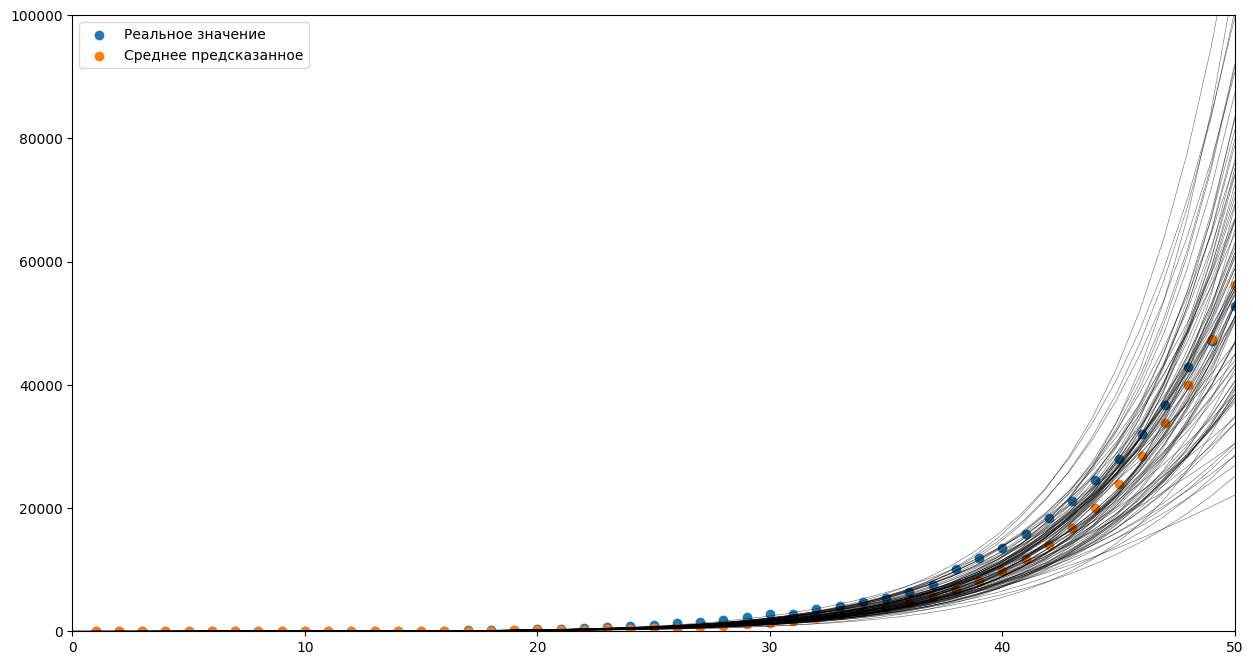

In [21]:
N = 50
xs = np.linspace(0, N, N)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.scatter(train['n_day'], train['total_cases'], label='Реальное значение')

total = myplot_sample_lines(mu, sigma, xs, N)

ax.scatter(train['n_day'], total.mean(axis=0), label='Среднее предсказанное')
ax.legend()
plt.show()

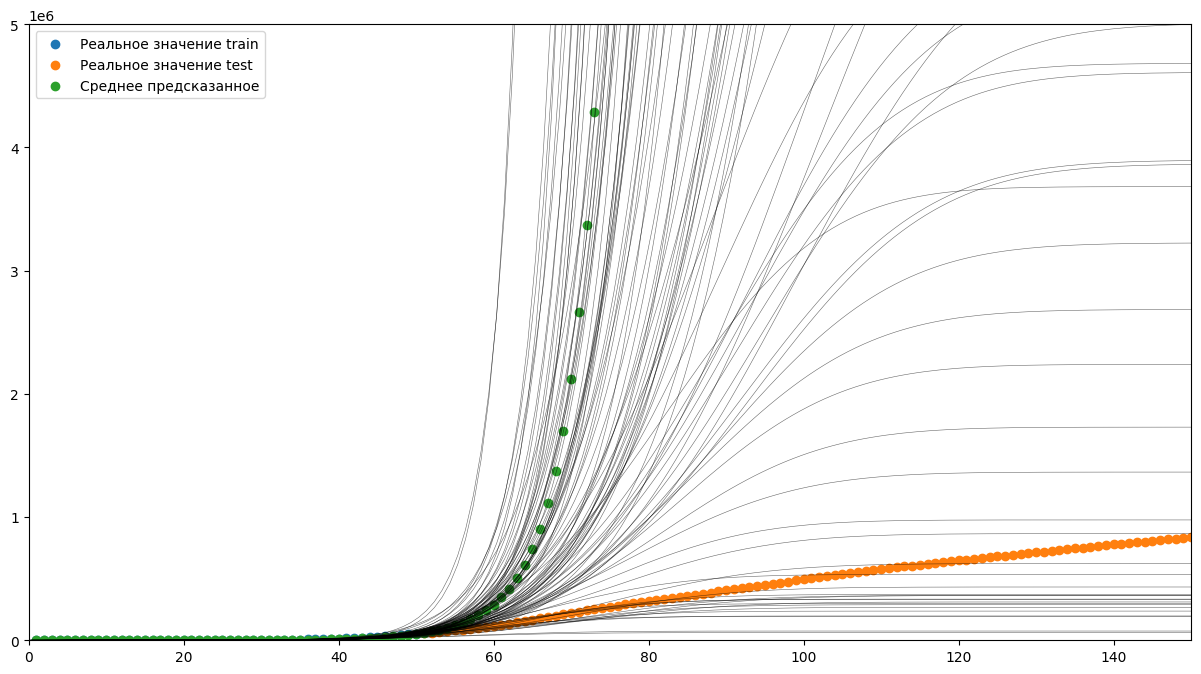

In [22]:
N = 150
xs = np.linspace(0, N, N)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

ax.scatter(train['n_day'], train['total_cases'], label='Реальное значение train')
ax.scatter(test['n_day'][:N], test['total_cases'][:N], label='Реальное значение test')

total = myplot_sample_lines(mu, sigma, xs, N, 5e6)

ax.scatter(pd.concat([train, test])['n_day'][:N], total.mean(axis=0), label='Среднее предсказанное')
ax.legend()
plt.show()

In [23]:
xs = np.array(range(1, 200))
my_w = np.random.multivariate_normal(mu, sigma, 200)

distrs = []

for w in my_w:
    distrs.append(np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2)))
    
mean_distrs = np.array(distrs).mean(axis=0)

Оптимистичный прогноз общего числа заболевших к 2020-05-01 212 человек
Пессимистичный прогноз общего числа заболевших к 2020-05-01 60159386676553624 человек
Оптимистичный прогноз общего числа заболевших к 2020-06-01 326 человек
Пессимистичный прогноз общего числа заболевших к 2020-06-01 260829 человек
Оптимистичный прогноз общего числа заболевших к 2020-09-01 269 человек
Пессимистичный прогноз общего числа заболевших к 2020-09-01 31917823 человек


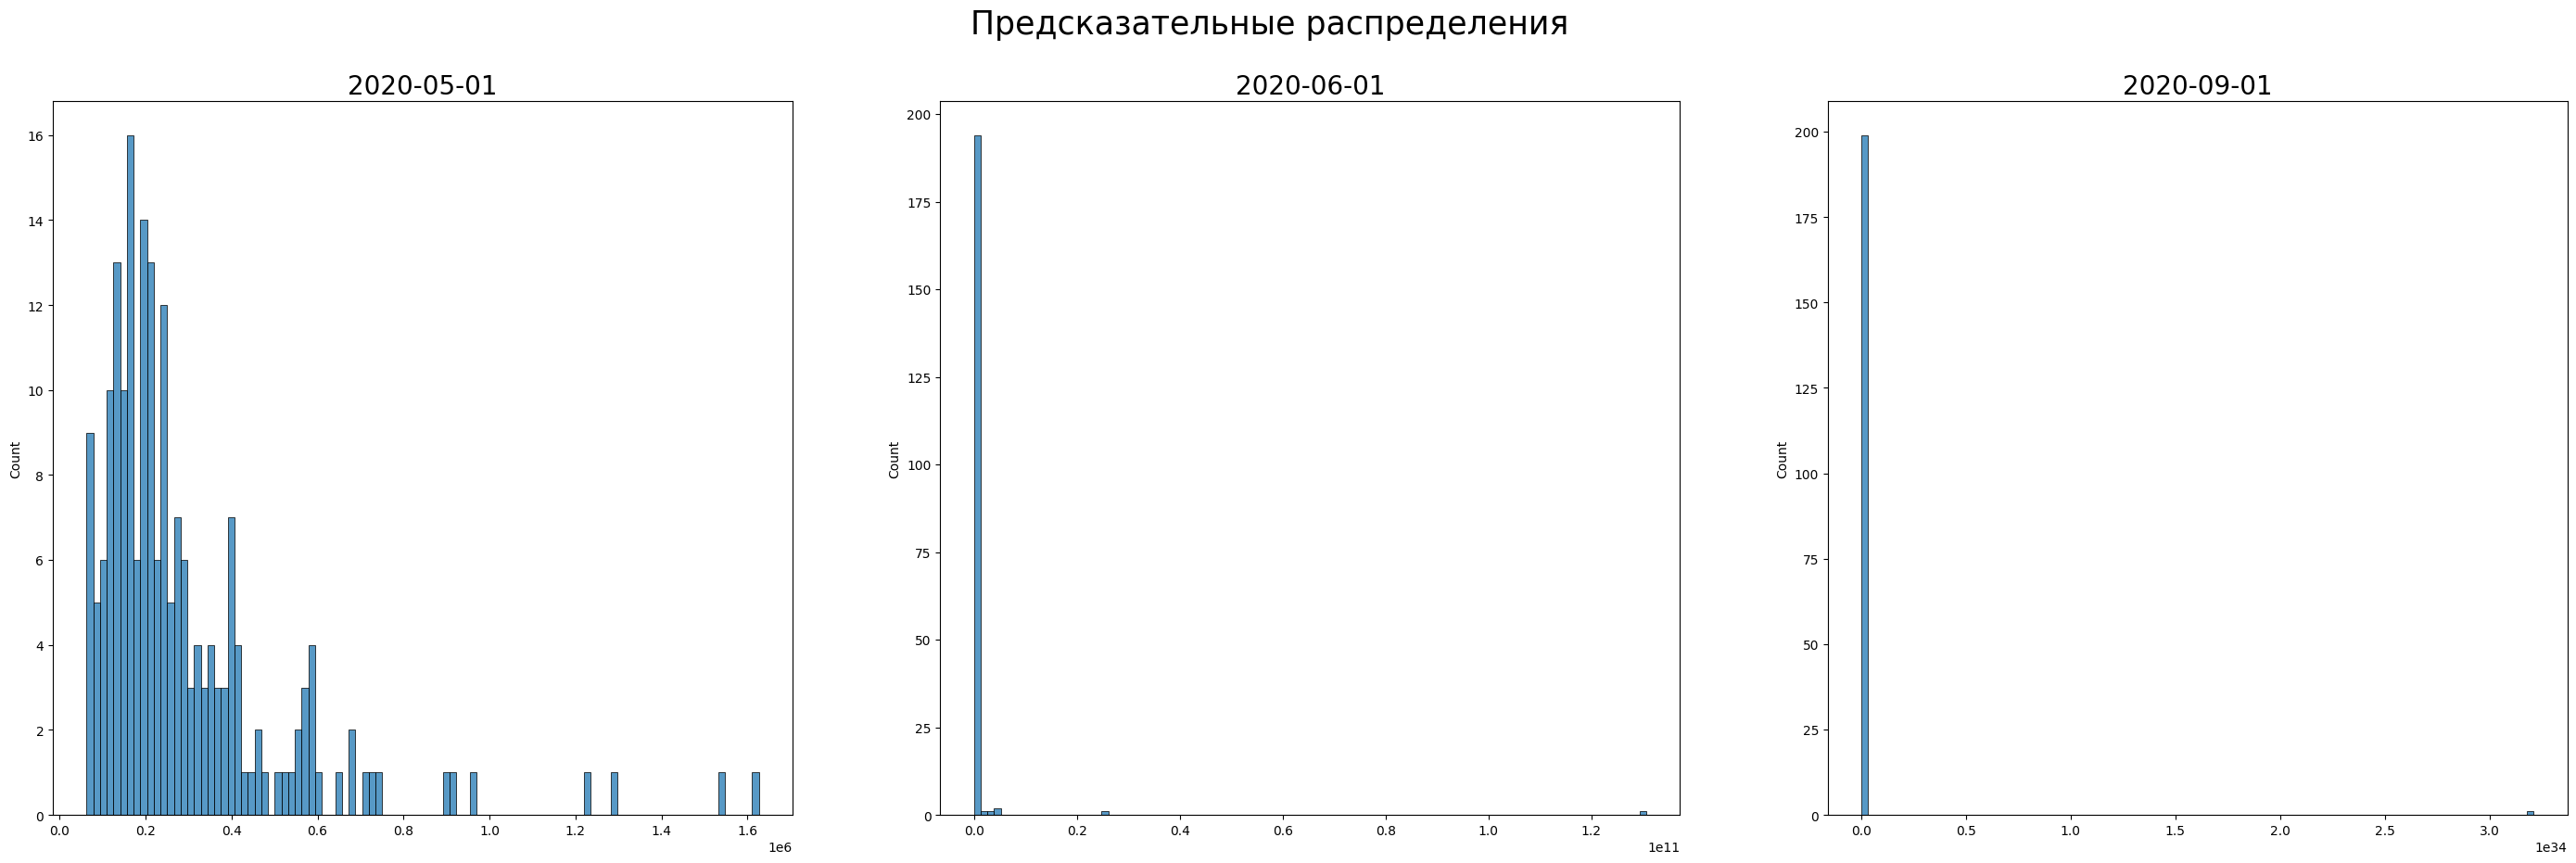

In [24]:
dates = ['2020-05-01','2020-06-01','2020-09-01']

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
plt.suptitle('Предсказательные распределения', fontsize=25)

for i, date in enumerate(dates):
    n_day = (pd.to_datetime(date) - train.date.min()).days
    sns.histplot(np.array(distrs)[:, n_day], ax=ax[i], bins=100)
    ax[i].set_title(f'{date}', fontsize=20)
    print(f'Оптимистичный прогноз общего числа заболевших к {date} {int(np.quantile(np.array(distrs)[n_day], 0.1))} человек')
    print(f'Пессимистичный прогноз общего числа заболевших к {date} {int(np.quantile(np.array(distrs)[n_day], 0.9))} человек')

4.	Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

5.	Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?